In [1]:
import ugali
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import fitsio
from astropy.table import Table
import healpy as hp
import healsparse as hsp
import skyproj
import IsochroneConfig as isoConfig

Reading fracdet map /hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz ...
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT
Ordering converted to RING


In [2]:
res = isoConfig.res
perCovered = isoConfig.perCovered
numMagBins = isoConfig.numMagBins
sigma = isoConfig.sigma
perMap = isoConfig.perMap
perVar = isoConfig.perVar
numBins = isoConfig.numBins
Class_Cutoff = isoConfig.classCutoff
goldCols = isoConfig.goldCols
qualityCuts = isoConfig.qualityCuts

In [3]:
dataPath = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/DwarfGalaxySandboxes/OnlyDetectionRates/'

In [4]:
# Try out 30, -35 for central pixel. "Why this pixel?" you might ask. It came to me in a dream lol.
center_ra, center_dec = 30, -35
proj = ugali.utils.projector.Projector(center_ra, center_dec)

In [5]:
center_pix = hp.ang2pix(32, center_ra, center_dec, lonlat = True, nest = True)

In [6]:
# These are the 9 healpix at 32 resolution simple search would use.
pixels = np.append(hp.pixelfunc.get_all_neighbours(32, center_pix, nest=True), center_pix)
pix32 = np.zeros(12*(32**2))
pix32[pixels] = 1

In [7]:
pix4096 = np.where(hp.ud_grade(pix32, 4096, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]
pix512 = np.where(hp.ud_grade(pix32, 512, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]
pix512Check = np.zeros(12*(512**2))
pix512Check[pix512] = 1
pixRes = np.where(hp.ud_grade(pix32, res, order_in = 'NESTED', order_out = 'NESTED') > 0)[0]
pixResCheck = np.zeros(12*(res**2))
pixResCheck[pixRes] = 1
ra4096, dec4096 = hp.pix2ang(4096, pix4096, lonlat = True, nest = True)
x4096, y4096 = proj.sphereToImage(ra4096, dec4096)
xMax = np.max(x4096) + 0.1
xMin = np.min(x4096) - 0.1
yMax = np.max(y4096) + 0.1
yMin = np.min(y4096) - 0.1

In [8]:
CSBinsCountFile = isoConfig.CSBinsCountFile

In [9]:
CS_Sum_Counts = []

for i in range(numMagBins):
    countsPix = fitsio.read(CSBinsCountFile)['PIX']
    fullCounts = np.full(12*(512**2), hp.UNSEEN)
    fullCounts[countsPix] = fitsio.read(CSBinsCountFile)[str(i)]
    croppedCounts = fullCounts[pix512]
    CS_Sum_Counts.append(int(np.round_(np.sum(croppedCounts[np.where(croppedCounts >= 0)[0]]) * len(croppedCounts) / len(np.where(croppedCounts >= 0)[0]))))

In [10]:
# starMockRa = []
# starMockDec = []
# starMockPix = []

# for sumIndex in range(len(CS_Sum_Counts)):

#     for i in range(1000):

#         keepLooping = True

#         mockRa = np.array([])
#         mockDec = np.array([])
#         mockPix = np.array([])

#         while keepLooping:
#             drawsX = (np.random.rand(100) * (xMax - xMin)) + xMin
#             drawsY = (np.random.rand(100) * (yMax - yMin)) + yMin
#             drawsRa, drawsDec = proj.imageToSphere(drawsX, drawsY)
#             drawsPix = hp.ang2pix(res, drawsRa, drawsDec, lonlat = True, nest = True)
#             mockRa = np.append(mockRa, drawsRa[np.where(pixResCheck[drawsPix] > 0)[0]])
#             mockDec = np.append(mockDec, drawsDec[np.where(pixResCheck[drawsPix] > 0)[0]])
#             mockPix = np.append(mockPix, drawsPix[np.where(pixResCheck[drawsPix] > 0)[0]])
#             if len(mockRa) >= CS_Sum_Counts[sumIndex]:
#                 keepLooping = False
#         mockRa = mockRa[:CS_Sum_Counts[sumIndex]]
#         mockDec = mockDec[:CS_Sum_Counts[sumIndex]]
#         mockPix = mockPix[:CS_Sum_Counts[sumIndex]]

#         if i == 0:
#             manyMockRaBin = np.atleast_2d(mockRa)
#             manyMockDecBin = np.atleast_2d(mockDec)
#             manyMockPixBin = np.atleast_2d(mockPix)
#         else:
#             manyMockRaBin = np.append(manyMockRaBin, np.atleast_2d(mockRa), axis = 0)
#             manyMockDecBin = np.append(manyMockDecBin, np.atleast_2d(mockDec), axis = 0)
#             manyMockPixBin = np.append(manyMockPixBin, np.atleast_2d(mockPix), axis = 0)
        
#     starMockRa.append(manyMockRaBin)
#     starMockDec.append(manyMockDecBin)
#     starMockPix.append(manyMockPixBin)

In [11]:
starDetProbFiles = isoConfig.starDetProbFiles

In [12]:
pixFile = isoConfig.pixFile
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(512**2), False, dtype = bool)
pixCheck[validPix] = True

In [13]:
starDetProbs = []
for i in range(len(starDetProbFiles)):
    fullSkyProb = np.full(12*(512**2), np.average(np.clip(fitsio.read(starDetProbFiles[i])['SIGNAL'], 0, 1)))
    fullSkyProb[validPix] = np.clip(fitsio.read(starDetProbFiles[i])['SIGNAL'], 0, 1)
    fullSkyProb = hp.ud_grade(fullSkyProb, res, order_in = 'NESTED', order_out = 'NESTED')
    starDetProbs.append(fullSkyProb)

In [14]:
firstTestPath = dataPath + 'FirstTest/'
secondTestPath = dataPath + 'SecondTest/'

In [15]:
# classifiedStarMockRa = []
# classifiedStarMockDec = []

# for magIndex in np.arange(len(starMockPix)):
    
#     manyMockStarClassRaBin = []
#     manyMockStarClassDecBin = []
    
#     for realization in np.arange(len(starMockPix[magIndex])):
#         # Random draws to assign classifications
#         randStarDet = np.random.rand(len(starMockPix[magIndex][realization]))
        
#         mockStarRa = starMockRa[magIndex][realization][np.where(randStarDet <= starDetProbs[magIndex][starMockPix[magIndex][realization].astype(int)])[0]]
#         mockStarDec = starMockDec[magIndex][realization][np.where(randStarDet <= starDetProbs[magIndex][starMockPix[magIndex][realization].astype(int)])[0]]
        
#         manyMockStarClassRaBin.append(mockStarRa)
#         manyMockStarClassDecBin.append(mockStarDec)
    
#     classifiedStarMockRa.append(manyMockStarClassRaBin)
#     classifiedStarMockDec.append(manyMockStarClassDecBin)

In [16]:
CLASS = 0
GMAG = [19.5, 20.5, 22.25, 23.25, 23.75]
RMAG = [19, 20, 22, 23, 23.5]
IMAG = 20
ZMAG = 20
MAG_ERR = 0
SIZE = 0.01

In [17]:
# for realization in np.arange(len(classifiedStarMockRa[0])):
#     my_table = Table()
    
#     RA_store = np.array([])
#     DEC_store = np.array([])
#     GMAG_store = np.array([])
#     RMAG_store = np.array([])
    
#     for magIndex in np.arange(len(classifiedStarMockRa)):
#         RA_store = np.append(RA_store, classifiedStarMockRa[magIndex][realization])
#         DEC_store = np.append(DEC_store, classifiedStarMockDec[magIndex][realization])
#         GMAG_store = np.append(GMAG_store, np.full(len(classifiedStarMockRa[magIndex][realization]), GMAG[magIndex]))
#         RMAG_store = np.append(RMAG_store, np.full(len(classifiedStarMockRa[magIndex][realization]), RMAG[magIndex]))
    
#     my_table['RA'] = RA_store
#     my_table['DEC'] = DEC_store
#     my_table['EXTENDED_CLASS_SOF'] = np.full(len(RA_store), CLASS)
#     my_table['SOF_PSF_MAG_G'] = GMAG_store
#     my_table['SOF_PSF_MAG_R'] = RMAG_store
#     my_table['SOF_PSF_MAG_I'] = np.full(len(RA_store), IMAG)
#     my_table['SOF_PSF_MAG_Z'] = np.full(len(RA_store), ZMAG)
#     my_table['SOF_CM_T'] = np.full(len(RA_store), SIZE)
#     my_table['SOF_PSF_MAG_ERR_G'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_R'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_I'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_Z'] = np.full(len(RA_store), MAG_ERR)
#     my_table.write(secondTestPath + "Classified_Star_" + str(realization) + ".fits", overwrite = True)

In [18]:
# for realization in np.arange(len(starMockRa[0])):
#     my_table = Table()
    
#     RA_store = np.array([])
#     DEC_store = np.array([])
#     GMAG_store = np.array([])
#     RMAG_store = np.array([])
    
#     for magIndex in np.arange(len(starMockRa)):
#         RA_store = np.append(RA_store, starMockRa[magIndex][realization])
#         DEC_store = np.append(DEC_store, starMockDec[magIndex][realization])
#         GMAG_store = np.append(GMAG_store, np.full(len(starMockRa[magIndex][realization]), GMAG[magIndex]))
#         RMAG_store = np.append(RMAG_store, np.full(len(starMockRa[magIndex][realization]), RMAG[magIndex]))
    
#     my_table['RA'] = RA_store
#     my_table['DEC'] = DEC_store
#     my_table['EXTENDED_CLASS_SOF'] = np.full(len(RA_store), CLASS)
#     my_table['SOF_PSF_MAG_G'] = GMAG_store
#     my_table['SOF_PSF_MAG_R'] = RMAG_store
#     my_table['SOF_PSF_MAG_I'] = np.full(len(RA_store), IMAG)
#     my_table['SOF_PSF_MAG_Z'] = np.full(len(RA_store), ZMAG)
#     my_table['SOF_CM_T'] = np.full(len(RA_store), SIZE)
#     my_table['SOF_PSF_MAG_ERR_G'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_R'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_I'] = np.full(len(RA_store), MAG_ERR)
#     my_table['SOF_PSF_MAG_ERR_Z'] = np.full(len(RA_store), MAG_ERR)
#     my_table.write(firstTestPath + "True_Star_" + str(realization) + ".fits", overwrite = True)

In [19]:
secondTestStarFiles = listdir(secondTestPath)

In [20]:
thirdTestPath = dataPath + 'ThirdTest/'

In [21]:
# for i in range(len(secondTestStarFiles)):
#     starData = fitsio.read(secondTestPath + secondTestStarFiles[i], columns = ['RA', 'DEC', 'SOF_PSF_MAG_R'])
#     starRA = starData['RA']
#     starDEC = starData['DEC']
#     starRMAG = starData['SOF_PSF_MAG_R']
#     starPIX = hp.ang2pix(res, starRA, starDEC, lonlat = True, nest = True)
    
#     starPixBins = []
    
#     for j in range(len(RMAG)):
#         starPixBins.append(starPIX[np.where(starRMAG == RMAG[j])[0]])
        
#     sumOrigStar = []
#     sumRecoStar = []
    
#     for j in range(len(starPixBins)):
#         fullOrigStar = np.zeros(12*(res**2))
#         for pix in starPixBins[j]:
#             fullOrigStar[pix] += 1
        
#         origStar = fullOrigStar[pixRes]
         
#         trueStarRecovered = origStar / starDetProbs[j][pixRes].astype(float)
        
#         sumOrigStar.append(origStar)
#         sumRecoStar.append(trueStarRecovered)
        
#     sumOrigStar = np.sum(sumOrigStar, axis = 0)
#     sumRecoStar = np.sum(sumRecoStar, axis = 0)
#     weights = sumRecoStar / sumOrigStar
    
#     strNum = ''
#     for char in secondTestStarFiles[i]:
#         if char.isdigit():
#             strNum += char
    
#     my_table = Table()
#     my_table['PIX'] = pixRes
#     my_table['CORRECTION'] = weights
#     my_table.write(thirdTestPath + "Weights_" + strNum + ".fits", overwrite = True)

In [22]:
first_sigs_file = dataPath + 'FirstTestSigs.fits'
first_sigs = fitsio.read(first_sigs_file)['SIGS']

second_sigs_file = dataPath + 'SecondTestSigs.fits'
second_sigs = fitsio.read(second_sigs_file)['SIGS']

third_sigs_file = dataPath + 'ThirdTestSigs.fits'
third_sigs = fitsio.read(third_sigs_file)['SIGS']

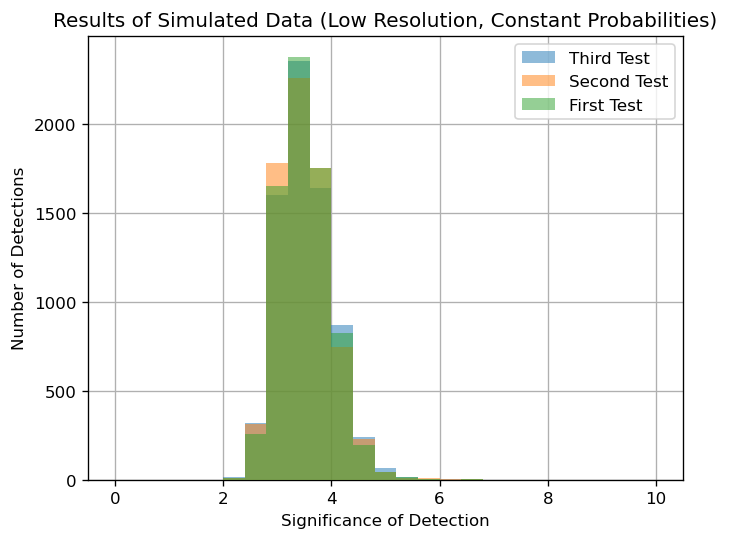

In [23]:
plt.figure(dpi = 120)
plt.hist(third_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5, label = 'Third Test', zorder = 3)
plt.hist(second_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5, label = 'Second Test', zorder = 3)
plt.hist(first_sigs, bins = np.linspace(0, 10, 26), alpha = 0.5, label = 'First Test', zorder = 3)
plt.legend()
plt.grid(zorder = 0)
plt.xlabel('Significance of Detection')
plt.ylabel('Number of Detections')
plt.title('Results of Simulated Data (Low Resolution, Constant Probabilities)')
# plt.yscale('log')
plt.show()